In [1]:
import os
import pandas as pd
import numpy as np
from datetime import date, timedelta
from pandas.tseries.offsets import BMonthEnd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
def readPayments(file_name, date_header="PaymentDate"):
    dataLoc = os.path.join(current_wd, "..", "data", file_name)
    paymentsData = pd.read_csv(dataLoc, index_col=date_header, parse_dates=True)
#     paymentsData[date_header] = pd.to_datetime(paymentsData[date_header])
    
    return paymentsData

def calcTaxPA(grossSalaryPA):
    '''calculates tax paid per year based on 
    UK tax bands'''
    taxFreeAllowance = 12500
    if grossSalaryPA <= taxFreeAllowance:
        taxPA = 0
    elif grossSalaryPA <= 50000:
        taxPA = 0.2*(grossSalaryPA - 12500)
    elif grossSalaryPA > 50000 and grossSalaryPA <= 150000:
        taxPA = (0.4*(grossSalaryPA - 50000)) + (0.2*(50000 - 12500))
    elif grossSalaryPA > 150000:
        taxPA = (0.45*(grossSalaryPA - 150000)) + (0.4*(150000 - 50000)) + (0.2*(50000 - 12500))
    return taxPA


def calcNICPA(grossSalaryPA):
    '''calculates national insurance contribution per year
    based on UK bands'''
    grossSalaryPW = grossSalaryPA/52
    if grossSalaryPW >= 962:
        NICPW = 0.02*(grossSalaryPW-962) + 0.12*(962-166)
    elif grossSalaryPW > 166:
        NICPW = 0.12*(grossSalaryPW - 166)
    else:
        NICPW = 0
    return NICPW*52


def calcStudentFinPM(grossSalaryPA):
    '''calculates student finance per year'''
    grossSalaryPM = grossSalaryPA/12
    thresholdPM = 2143
    if grossSalaryPM > thresholdPM:
        StudentFinPM = 0.09*(grossSalaryPM-thresholdPM)
    else:
        StudentFinPM = 0
    return StudentFinPM


def calcNetSalary(grossSalaryPA):
    '''calculates net salary after tax and all other deductions'''
    netSalaryPA = grossSalaryPA - calcTaxPA(grossSalaryPA) - calcNICPA(grossSalaryPA) - calcStudentFinPA(grossSalaryPA)
    return netSalaryPA


def salaryIncrease(grossSalaryPA, mean, sd):
    '''increase salary my random amount drawn from gaussian distribution'''
    increaseStep = np.random.normal(mean, sd)
    return grossSalaryPA+increaseStep

def findInterestRate(paymentDate):
    try:
        year = paymentDate.year
        sdate = historicInterest[str(year)]["start"]
        edate = historicInterest[str(year)]["end"]
        delta = edate - sdate
    
        allDates = [sdate + timedelta(days=i) for i in range(delta.days+1)] # create list of all dates in date range sdate to edate

        if paymentDate in allDates:
            rate = historicInterest[str(year)]["rate"]
        else:
            rate = historicInterest[str(year-1)]["rate"]
    except KeyError: # key error will occur for dates in years that have no published interest rate as they don't appear in dictionary
        rate = historicInterest[str(year-1)]["rate"]
    return rate


def populateInterestRate(myPayments):
    '''populates the interest rate column in the payments table'''
    myPayments["interestRate"] = 0
    myPayments["totalPayment"] = 0
    myPayments["cumulativeTotal"] = 0
    for i in myPayments.index:
        rate = findInterestRate(i.date())
        myPayments.loc[i,"interestRate"] = rate
        myPayments.loc[i, "totalPayment"] = myPayments.loc[i, "Gross"]*(rate+1)
        myPayments.loc[i, "cumulativeTotal"] = myPayments.loc[i, "Gross"]*(rate+1)
    return myPayments

def graduateAmount(simEnd, employmentStart, myPayments=None): # simEnd argument ends simulation either on the last payment in data, at the end of graduation academic year or at commencement of employment
    '''calculate student debt in graduation year'''
    cumulativeTotal = 0
    interestRate = 0
    if myPayments is not None:
        startDate = myPayments.index.min()
        if simEnd == "yearEnd":
            graduationYear = myPayments.index.max().year # assumes that final payment occurs during graduation year
            yearEnd = str(graduationYear)+"-08-31"
            endDate = pd.Timestamp(yearEnd) # simulation ends at end of academic year of final payment
        elif simEnd == "employment":
            endDate = pd.Timestamp(employmentStart)
        else:
            endDate = myPayments.index.max() # simulation ends at final payment

        delta = timedelta(days=1)
        
        while startDate <= endDate: # up to and including final payment
            interestRate = findInterestRate(startDate)
            cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
            if startDate in myPayments.index:
                cumulativeTotal += myPayments.loc[startDate]["Gross"]
            startDate += delta                
            
    else:
        print("Please enter your net total of Student Debt at graduation")
        cumulativeTotal = input()
    return cumulativeTotal

def loanAtEmployment(principal, principal_date, employment_start):
    '''when payment data is absent, plug in last statement amount and date'''
    endDate = pd.Timestamp(employment_start)
    startDate = principal_date
    cumulativeTotal = principal
    delta = timedelta(days=1)
    
    while startDate <= endDate: # up to and including final payment
        interestRate = findInterestRate(startDate)
        cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
        startDate += delta
    return cumulativeTotal

def simulateLifetimeEarnings(grossSalaryPA, N, principal, employment_start, frequency, mean_salary_increase, mean_salary_sd):
    '''Simulates payment of student debt across career based on monthly tax payments according to
    estimate salary and compounding interest of loan'''
    lifetime_tax = 0
    lifetime_SF = 0
    lifetime_NIC = 0
    lifetime_earning = 0
    
    today = pd.Timestamp(employment_start)
    start = today
    edate = today + timedelta(days=N*365)
    delta = timedelta(days=1)

    offset = BMonthEnd()
    
    cumulativeTotal = principal
    cumulativeList = []
    cumulativeList.append(cumulativeTotal)
    while today <= edate:
        if ((today - start).days/365)%frequency == 0 and ((today - start).days/365) > 0:
            grossSalaryPA = salaryIncrease(grossSalaryPA, mean=mean_salary_increase, sd=mean_salary_sd)
        
        cumulativeTotal *= (1+(0.05/365)) # apply interest on previous payments before new payment
        
        if today == offset.rollforward(today) and today.month == offset.rollforward(today).month: # if today in sim is last working day
            cumulativeTotal -= calcStudentFinPM(grossSalaryPA)
            cumulativeList.append(cumulativeTotal)
            
        today += delta

    return cumulativeList

In [53]:
current_wd = os.getcwd()
file_name = "trimmed_data.csv"
myPayments = readPayments(file_name)

In [54]:
## Web scrape historic interest rates

url = 'https://www.gov.uk/guidance/how-interest-is-calculated-plan-2'
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find('table')
table_rows = results.find_all('tr')
historicInterest = {}
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    if len(row) > 0:
        row[0] = row[0].split('to')
        row[0][0] = pd.Timestamp(row[0][0])
        row[0][1] = pd.Timestamp(row[0][1])
        year = str(row[0][0].year)
        historicInterest.setdefault(year, 0)
        historicInterest[year] = {}
        historicInterest[year].setdefault("start", 0)
        historicInterest[year]["start"] = row[0][0].date()
        historicInterest[year].setdefault("end", 0)
        historicInterest[year]["end"] = row[0][1].date()
        historicInterest[year].setdefault("rate", 0)
        historicInterest[year]["rate"] = float(row[1][:-1])/100

In [105]:
cumulativeList = simulateLifetimeEarnings(grossSalaryPA = 35000, 
                                          N = 30, 
                                          principal = graduateAmount(simEnd = "employment", employmentStart = "2019-10-07", myPayments = myPayments), 
                                          employment_start = "2019-10-07", 
                                          frequency = 5, 
                                          mean_salary_increase = 3000, 
                                          mean_salary_sd = 2500)

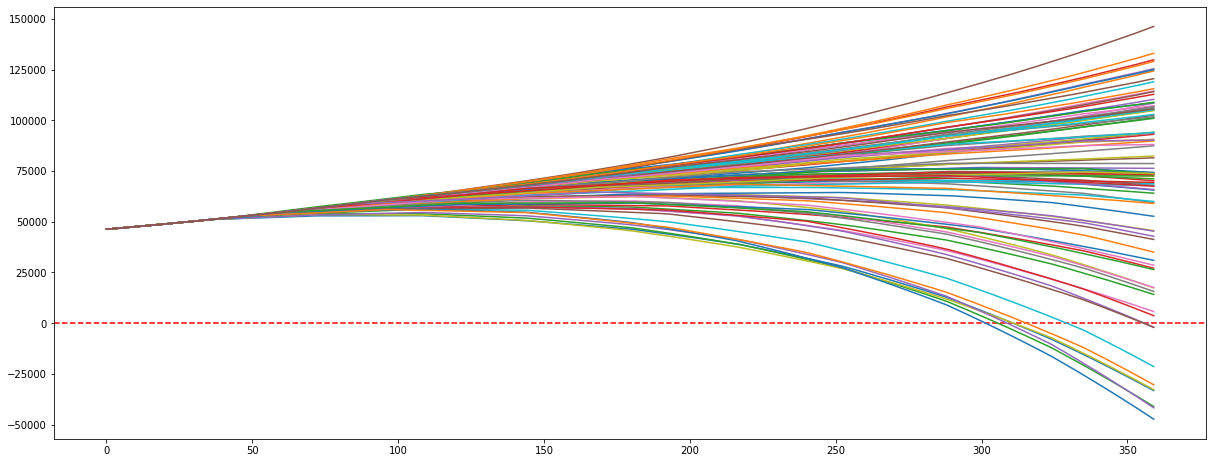

In [117]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_axes([0,0,1,1])
plt.axhline(y = 0, color = 'r', linestyle = '--')
salary_increases = np.arange(3000,11000,500)    
salary_increases_frequency = np.arange(3,9,1)
trajectories = np.zeros((len(salary_increases),len(salary_increases_frequency)))
for i in range(len(salary_increases)):
    for j in range(len(salary_increases_frequency)):
        sim = simulateLifetimeEarnings(grossSalaryPA = 35000, 
                                N = 30, 
                                principal = graduateAmount(simEnd = "employment", employmentStart = "2019-10-07", myPayments = myPayments), 
                                employment_start = "2019-10-07", 
                                frequency = salary_increases_frequency[j], 
                                mean_salary_increase = salary_increases[i], 
                                mean_salary_sd = 2500)
        trajectories[i,j] = sim[-1]
        
        ax.plot(sim)

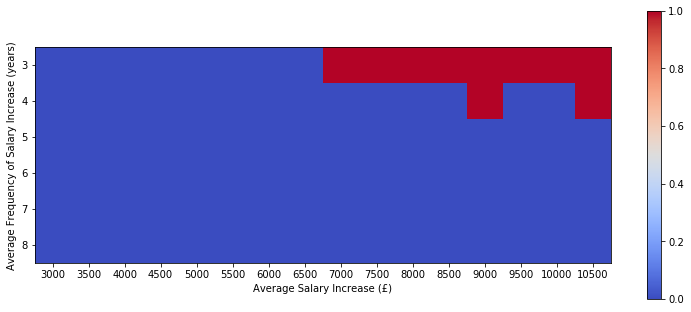

In [103]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])

# We want to show all ticks...
ax.set_xticks(np.arange(len(salary_increases)))
ax.set_xlabel('Average Salary Increase (£)')
ax.set_yticks(np.arange(len(salary_increases_frequency)))
ax.set_ylabel('Average Frequency of Salary Increase (years)')
# ... and label them with the respective list entries
ax.set_xticklabels(salary_increases)
ax.set_yticklabels(salary_increases_frequency)

heatmap = ax.imshow(yaynay.astype(int).transpose(), cmap='coolwarm', interpolation='nearest')
# ax.imshow()
fig.colorbar(heatmap)